# Model

## Task definition:

Our aim is to define model that will work with unbalanced data, what can we achieve by Deep Learning methods with the proper metrics and loss functions.

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from focal_loss.focal_loss import FocalLoss
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

print('GPU: ', torch.backends.mps.is_available()) 
print('GPU built: ', torch.backends.mps.is_built())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print('device: ', device)

GPU:  True
GPU built:  True
device:  mps


In [2]:
# function faster than pd.dummies
def transofrm(data):
    
    label_encoder = LabelEncoder()

    for column in data.columns:
        if data[column].dtype == 'object':  
            data[column] = label_encoder.fit_transform(data[column])

    return data

In [3]:
df_train = pd.read_csv('fraudTrain.csv')
df_test = pd.read_csv('fraudTest.csv')
df_train = df_train.drop(columns='Unnamed: 0')
df_test = df_test.drop(columns='Unnamed: 0')
df_train = df_train.dropna()
df_test = df_test.dropna()
df_train.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

Even though Deep Learning models don't require feature engineering part, in case scenarios demanding more features is always a cost. Due to Occam's Razor.
Because of categorical variables there is a need of Spearman method usage (what's more, non-linear dependencies will be captured)

/var/folders/7c/_23sx7kx1_d601cst8gcyt1m0000gn/T/ipykernel_92013/2173641440.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_train.corr()


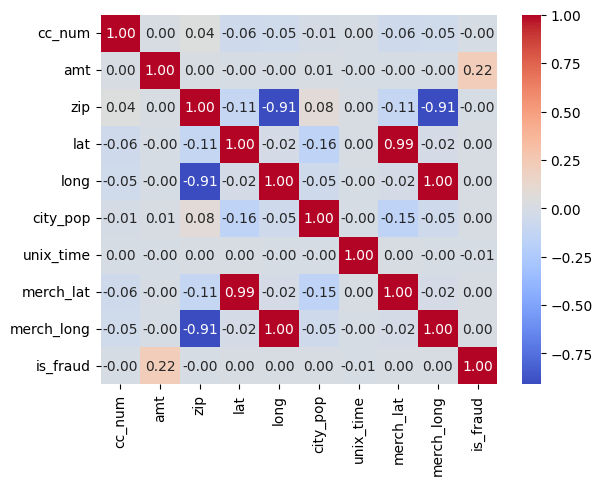

In [4]:
correlation_matrix = df_train.corr()

sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.show()

In [5]:
df_train = df_train.drop(columns='merch_lat')
df_train = df_train.drop(columns='merch_long')
df_train = df_train.drop(columns='zip')

df_test = df_test.drop(columns='merch_lat')
df_test = df_test.drop(columns='merch_long')
df_test = df_test.drop(columns='zip')
print('features number: ', df_train.shape[1])

features number:  19


In [6]:
df_train = transofrm(df_train)
train_features = df_train.drop(columns=['is_fraud'])
train_labels = df_train['is_fraud']

df_test= transofrm(df_test)
test_features = df_test.drop(columns=['is_fraud'])
test_labels = df_test['is_fraud']
print('features number: ', train_features.shape[1])

features number:  18


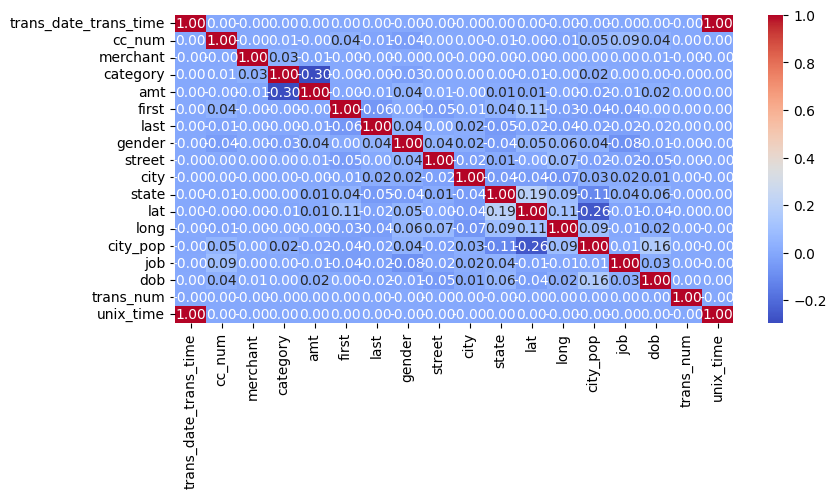

In [7]:
correlation_matrix = train_features.corr(method='spearman')

plt.figure(figsize=(9,4))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.show()

In [8]:
train_features = train_features.drop(columns='trans_date_trans_time')

test_features = test_features.drop(columns='trans_date_trans_time')
print('features number: ', train_features.shape[1])

features number:  17


## Deep Learing Metrics

-Sensitivity and Specificity are better for imbalanced data

Especially crucial is sensitivity because it measures correctly classified positive samples with respect to the total number of positive samples

In [9]:
count_classes = df_train['is_fraud'].value_counts()

possitive_class = count_classes[1]
negative_class = count_classes[0]

Positive class is much fewer represented that's why the model supposed to pay more attention to it during training.

In [10]:
pos_weight = torch.tensor(10000)

## Dataset

In [11]:
sc = StandardScaler()
train_features = sc.fit_transform(train_features)
test_features = sc.fit_transform(test_features)

train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

print('train classes: ', np.unique(train_labels_tensor, return_counts=True))
print('test classes: ', np.unique(test_labels_tensor, return_counts=True))
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

train classes:  (array([0., 1.], dtype=float32), array([1289169,    7506]))
test classes:  (array([0., 1.], dtype=float32), array([553574,   2145]))


## ANN Model

In [12]:
from torch.nn import Linear
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_features, output_classes):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = nn.Linear(input_features, input_features)
        self.lin2 = nn.Linear(input_features, input_features//2)
        self.lin3 = nn.Linear(input_features//2, input_features//4)
        self.lin4 = nn.Linear(input_features//4, output_classes )

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = self.lin3(x)
        x = F.relu(x)
        x = self.lin4(x)
        
        return x

model = MLP(train_features.shape[1], 1).to(device)
print(model)

MLP(
  (lin1): Linear(in_features=17, out_features=17, bias=True)
  (lin2): Linear(in_features=17, out_features=8, bias=True)
  (lin3): Linear(in_features=8, out_features=4, bias=True)
  (lin4): Linear(in_features=4, out_features=1, bias=True)
)


## Training
During training we can see how not trustworthy accuracy is for unbalanced data, after one epoch (with Sensitivity equal to 0 and huge loss) we achieve over 99% accuracy. That's why it is important to be aware of distributions that the dataset follows and properties measured by our metrics. 
That example shows also how ineffective could be early on the test set results, even if they don't improve much, we see a huge improvement in the loss function.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.09)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = torch.nn.BCELoss(weight=pos_weight)
#criterion = FocalLoss(gamma=0.7)
epochs = 300
 
def train(threshold = 0.5):
    model.train()
    tot_loss = 0
    
    for data in train_loader: 
        out = model(data[0].to(device))  
        out = torch.sigmoid(out)
        binary_predictions = (torch.sigmoid(out) > threshold).squeeze() 
        
        loss = criterion(binary_predictions, data[1].to(device))  
        loss.backward()  
        optimizer.step()  
        optimizer.zero_grad()  
        tot_loss = tot_loss + loss
        
    return tot_loss

def test(loader, threshold = 0.5):
    model.eval()
    total_acc = 0
    total_sensitivity = 0

    with torch.no_grad():
        for data in loader:
            inputs, targets = data[0].to(device), data[1].to(device)
            
            out = model(inputs)
            out = torch.sigmoid(out)
            binary_predictions = (torch.sigmoid(out) > threshold).squeeze() 

            acc = torch.mean((out.round().squeeze() == targets).float()) * 100
            total_acc += acc.item()

            true_positives = torch.sum((out.round().squeeze() == 1) & (targets == 1)).float()
            actual_positives = torch.sum(targets == 1).float()
            sensitivity = true_positives / actual_positives if actual_positives != 0 else 0
            total_sensitivity += sensitivity

    avg_acc = total_acc / len(loader)
    avg_sensitivity = total_sensitivity / len(loader)

    return avg_acc, avg_sensitivity

for epoch in range(1, epochs):
    loss = train(0.1)
    train_acc, train_sens = test(train_loader, 0.1)
    test_acc, test_sens = test(test_loader, 0.1)
    print(f'Epoch: {epoch}, Train Loss: {loss}, Train Acc: {train_acc},\
    Train Sens: {train_sens}, Test Acc: {test_acc}, Test Sens: {test_sens}')